### 훈련 및 검증 데이터셋 분리
- 훈련 데이터셋과 검증 데이터셋 각각을 생성하기 위한 두 개의 클래스 생성
    - 검증 데이터셋 생성을 위한 Luna2dSegmentationDataset 클래스
    - 이 클래스를 상속받아 랜덤화(shuffle)와 잘라내기(crop)를 추가한 훈련 데이터셋 생성을 위한 서브클래스

### 검증(validation) 데이터셋
- 검증용 CT 단면당 하나의 양성 마스크를 가진 샘플을 생성
    - 앞서 만들어놓은 CT 스캔의 사이즈와 양성 마스크(positive_indexes) 캐싱 함수(getCtSampleSize)를 활용
    - 일일이 데이터를 로딩하여 확인하지 않아도 전체 검증 데이터셋을 빠르게 생성 가능

### Luna2dSegmentationDataset

In [ ]:
# dsets.py

class Luna2dSegmentationDataset(Dataset):
    # __init__에서 정의된 속성들 모두 TrainingLuna2dSegmentationDataset 클래스로 상속
    def __init__(self,
                 val_stride=0,
                 isValSet_bool=None, # 검증(또는 훈련) 데이터셋을 구성하고자 하는지 여부
                 series_uid=None,
                 contextSlices_count=3, # 위아래 각각 인접한 단면의 개수 (총 6장의 인접한 단면을 사용)
                 fullCt_bool=False, # 데이터셋의 모든 CT 단면에 대해 검증을 수행할지 여부
            ):
        self.contextSlices_count = contextSlices_count
        self.fullCt_bool = fullCt_bool

        if series_uid:
            self.series_list = [series_uid]
        else:
            self.series_list = sorted(getCandidateInfoDict().keys()) # 전체 CT 스캔 리스트의 series_uid

        # 훈련셋과 검증셋을 구분하는 플래그
        if isValSet_bool:
            assert val_stride > 0, val_stride
            self.series_list = self.series_list[::val_stride] # val_stride 인덱스의 데이터만 검증 데이터셋에 포함
            assert self.series_list
        elif val_stride > 0:
            del self.series_list[::val_stride] # val_stride 인덱스의 데이터를 제외한 나머지 데이터를 모두 훈련 데이터셋에 포함
            assert self.series_list

        # 언제 검증을 수행할지 결정하는 플래그
        self.sample_list = []
        for series_uid in self.series_list:
            index_count, positive_indexes = getCtSampleSize(series_uid) # 전체 단면 수, 양성 단면 인덱스

            if self.fullCt_bool: # 전체 CT 단면에 대해 검증을 수행
                self.sample_list += [(series_uid, slice_ndx)
                                     for slice_ndx in range(index_count)] # sample_list를 전체 단면으로 확장
            else: # 양성 마스크가 있는 CT 단면에 대해서만 훈련 시에 검증을 수행
                self.sample_list += [(series_uid, slice_ndx)
                                     for slice_ndx in positive_indexes] # positive_indexes에 해당하는 단면만 사용

        self.candidateInfo_list = getCandidateInfoList()

        series_set = set(self.series_list) # 중복 제거
        self.candidateInfo_list = [cit for cit in self.candidateInfo_list
                                   if cit.series_uid in series_set]

        self.pos_list = [nt for nt in self.candidateInfo_list
                            if nt.isNodule_bool] # 결절 정보만 포함하는 리스트

        log.info("{!r}: {} {} series, {} slices, {} nodules".format(
            self,
            len(self.series_list),
            {None: 'general', True: 'validation', False: 'training'}[isValSet_bool],
            len(self.sample_list),
            len(self.pos_list),
        ))

    def __len__(self):
        return len(self.sample_list)

    # __getitem__: 인덱스로 접근할 수 있는 iterator (https://dojang.io/mod/page/view.php?id=2407)
    # 샘플의 인덱싱(추출)을 쉽게 해주는 함수로, 특정 series_uid나 위치에 대한 단면이 필요할 때 유용

    def __getitem__(self, ndx): # 정수로 된 인덱스를 전달하면 셔플된 리스트에서 샘플 추출 가능
        series_uid, slice_ndx = self.sample_list[ndx % len(self.sample_list)]
        return self.getitem_fullSlice(series_uid, slice_ndx)

    def getitem_fullSlice(self, series_uid, slice_ndx):
        ct = getCt(series_uid)
        ct_t = torch.zeros((self.contextSlices_count * 2 + 1, 512, 512)) # 출력 공간을 미리 할당 (C * H * W)

        start_ndx = slice_ndx - self.contextSlices_count # 배치의 처음 단면
        end_ndx = slice_ndx + self.contextSlices_count + 1 # 마지막 단면

        for i, context_ndx in enumerate(range(start_ndx, end_ndx)):

            # ct_a 경계를 넘어가는 단면에 대한 처리
            context_ndx = max(context_ndx, 0)
            context_ndx = min(context_ndx, ct.hu_a.shape[0] - 1)

            ct_t[i] = torch.from_numpy(ct.hu_a[context_ndx].astype(np.float32)) # C(채널)개 단면의 픽셀값

        ct_t.clamp_(-1000, 1000) # 이상치 제거

        pos_t = torch.from_numpy(ct.positive_mask[slice_ndx]).unsqueeze(0)

        return ct_t, pos_t, ct.series_uid, slice_ndx # ct_t, pos_t 정보만 훈련에 사용 (나머지는 디버깅과 출력을 위한 정보)

### 훈련(training) 데이터셋
- CT 단면 전체 대신 양성 후보 주위를 64 * 64로 잘라낸 것으로 훈련 (실제 결절 후보 하나)
    - 결절이 가운데 위치한 96 * 96 패치에서 랜덤하게 잘라낸 것
    - 이 데이터의 위아래에 위치하는 세 개의 단면까지 추가 채널로 포함
- CT 단면 전체를 훈련에 사용하면 class imbalance 문제가 발생
    - 전체 단면 크기에 비해 결절이 너무 작기 때문이며, 이전 장에서 발생한 문제와 유사 (400:1)
- 훈련을 안정적으로 동작시키고 빠르게 수렴하게 만들기 위해 일부를 랜덤 크롭하는 방식을 사용
    - 결절이 있는 양성 픽셀을 최대한 유지하며 음성 픽셀 수를 큰 폭으로 줄이는 것
    - 64 * 64 패치로 크롭하는 것은 여러 세팅의 실험을 통해 얻은 경험적인 결과

### TrainingLuna2dSegmentationDataset

In [ ]:
# dsets.py

class TrainingLuna2dSegmentationDataset(Luna2dSegmentationDataset): # 검증셋 클래스를 상속
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.ratio_int = 2

    def __len__(self):
        return 300000

    def shuffleSamples(self):
        random.shuffle(self.candidateInfo_list)
        random.shuffle(self.pos_list)

    # 훈련셋용 __getitem__ 함수
    def __getitem__(self, ndx):
        candidateInfo_tup = self.pos_list[ndx % len(self.pos_list)] # 결절의 정확한 중심 위치가 필요하므로 pos_list로 구성
        return self.getitem_trainingCrop(candidateInfo_tup)

    def getitem_trainingCrop(self, candidateInfo_tup):
        ct_a, pos_a, center_irc = getCtRawCandidate( # CT 데이터, 양성 마스크, 중심점
            candidateInfo_tup.series_uid,
            candidateInfo_tup.center_xyz,
            (7, 96, 96), # 인접 단면들까지 7개의 채널, 96 * 96 패치
        )
        pos_a = pos_a[3:4] # 7개의 채널 중 실제 세그멘테이션을 진행하는 중앙부 단면

        row_offset = random.randrange(0,32) # 0과 31 사이의 임의의 숫자 두 개(행과 열)를 시작점으로 CT와 마스크를 크롭
        col_offset = random.randrange(0,32)

        # 행과 열 각각의 시작점으로부터 64를 더하여 64 * 64 패치 생성
        ct_t = torch.from_numpy(ct_a[:, row_offset:row_offset+64,
                                     col_offset:col_offset+64]).to(torch.float32)
        pos_t = torch.from_numpy(pos_a[:, row_offset:row_offset+64,
                                       col_offset:col_offset+64]).to(torch.long)

        slice_ndx = center_irc.index

        return ct_t, pos_t, candidateInfo_tup.series_uid, slice_ndx # 검증 데이터셋과 동일한 항목의 튜플을 반환

### Data Augmentation
- 과적합을 피하기 위한 데이터 증강
- 이전 장에서 다룬 증강과 매우 유사한 2차원 데이터의 증강을 클래스로 구현

In [ ]:
# model.py

class SegmentationAugmentation(nn.Module):
    def __init__(
            self, flip=None, offset=None, scale=None, rotate=None, noise=None
    ):
        super().__init__()

        # 이전 장과 동일한 형태의 증강
        self.flip = flip
        self.offset = offset
        self.scale = scale
        self.rotate = rotate
        self.noise = noise

    # 증강된 transform_t를 아핀 변환(affine transformation)
    def forward(self, input_g, label_g): # input은 CT 데이터, label은 마스크 정보
        transform_t = self._build2dTransformMatrix()
        transform_t = transform_t.expand(input_g.shape[0], -1, -1) # 2차원 데이터 증강
        transform_t = transform_t.to(input_g.device, torch.float32)

        # 아핀 변환
        affine_t = F.affine_grid(transform_t[:,:2], # 첫 번째 차원은 배치 영역, 두 번째 차원에서 3 * 3 행렬의 첫 두 개 행만 사용
                input_g.size(), align_corners=False)

        # CT와 마스크에 동일한 변환이 적용되므로 같은 그리드를 사용
        augmented_input_g = F.grid_sample(input_g,
                affine_t, padding_mode='border',
                align_corners=False)
        augmented_label_g = F.grid_sample(label_g.to(torch.float32),
                affine_t, padding_mode='border',
                align_corners=False)

        if self.noise:
            noise_t = torch.randn_like(augmented_input_g)
            noise_t *= self.noise

            augmented_input_g += noise_t

        return augmented_input_g, augmented_label_g > 0.5 # 마스크를 0.5와 비교한 boolean 값으로 변환

    # 실제로 증강을 수행하여 transform_t를 반환하는 함수 (flip, offset, scale, rotate)
    def _build2dTransformMatrix(self):
        transform_t = torch.eye(3) # 증강에 사용할 3 * 3 단위행렬

        for i in range(2): # 2차원 데이터의 증강이므로 range(2)
            if self.flip:
                if random.random() > 0.5:
                    transform_t[i,i] *= -1

            if self.offset:
                offset_float = self.offset
                random_float = (random.random() * 2 - 1)
                transform_t[2,i] = offset_float * random_float

            if self.scale:
                scale_float = self.scale
                random_float = (random.random() * 2 - 1)
                transform_t[i,i] *= 1.0 + scale_float * random_float

        if self.rotate:
            angle_rad = random.random() * math.pi * 2 # rotate를 위한 0 ~ 2{pi} 범위의 랜덤 각 생성 (단위: radian)
            s = math.sin(angle_rad)
            c = math.cos(angle_rad)

            rotation_t = torch.tensor([ # 단위행렬의 처음 두 차원에 대한 랜덤 각으로 2차원 회전을 위한 회전행렬을 정의
                [c, -s, 0],
                [s, c, 0],
                [0, 0, 1]])

            transform_t @= rotation_t # python 행렬곱 연산자를 사용하여 transform_t 회전

        return transform_t

## 13.6 세그멘테이션을 위한 훈련 스크립트 업데이트
- 이전 장의 훈련 코드와 매우 유사하며, 출력에 영향을 미치는 세 가지를 업데이트
    - 새로운 모델 인스턴스 정의
    - 다이스 손실 도입
    - 아담(Adam) 옵티마이저 도입

### 훈련 클래스 생성자

In [ ]:
# training.py

class SegmentationTrainingApp:
    def __init__(self, sys_argv=None):
        if sys_argv is None:
            sys_argv = sys.argv[1:]

        parser = argparse.ArgumentParser()
        parser.add_argument('--batch-size',
            help='Batch size to use for training',
            default=16,
            type=int,
        )
        parser.add_argument('--num-workers',
            help='Number of worker processes for background data loading',
            default=8,
            type=int,
        )
        parser.add_argument('--epochs',
            help='Number of epochs to train for',
            default=1,
            type=int,
        )

        parser.add_argument('--augmented',
            help="Augment the training data.",
            action='store_true',
            default=False,
        )
        parser.add_argument('--augment-flip',
            help="Augment the training data by randomly flipping the data left-right, up-down, and front-back.",
            action='store_true',
            default=False,
        )
        parser.add_argument('--augment-offset',
            help="Augment the training data by randomly offsetting the data slightly along the X and Y axes.",
            action='store_true',
            default=False,
        )
        parser.add_argument('--augment-scale',
            help="Augment the training data by randomly increasing or decreasing the size of the candidate.",
            action='store_true',
            default=False,
        )
        parser.add_argument('--augment-rotate',
            help="Augment the training data by randomly rotating the data around the head-foot axis.",
            action='store_true',
            default=False,
        )
        parser.add_argument('--augment-noise',
            help="Augment the training data by randomly adding noise to the data.",
            action='store_true',
            default=False,
        )

        parser.add_argument('--tb-prefix',
            default='p2ch13',
            help="Data prefix to use for Tensorboard run. Defaults to chapter.",
        )

        parser.add_argument('comment',
            help="Comment suffix for Tensorboard run.",
            nargs='?',
            default='none',
        )

        self.cli_args = parser.parse_args(sys_argv)
        self.time_str = datetime.datetime.now().strftime('%Y-%m-%d_%H.%M.%S')
        self.totalTrainingSamples_count = 0
        self.trn_writer = None
        self.val_writer = None

        # 데이터 증강에 활용할 파라미터
        self.augmentation_dict = {}
        if self.cli_args.augmented or self.cli_args.augment_flip:
            self.augmentation_dict['flip'] = True
        if self.cli_args.augmented or self.cli_args.augment_offset:
            self.augmentation_dict['offset'] = 0.03
        if self.cli_args.augmented or self.cli_args.augment_scale:
            self.augmentation_dict['scale'] = 0.2
        if self.cli_args.augmented or self.cli_args.augment_rotate:
            self.augmentation_dict['rotate'] = True
        if self.cli_args.augmented or self.cli_args.augment_noise:
            self.augmentation_dict['noise'] = 25.0

        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if self.use_cuda else "cpu")

        self.segmentation_model, self.augmentation_model = self.initModel() # 모델 초기화
        self.optimizer = self.initOptimizer() # 옵티마이저 초기화

### 모델 초기화
- 세그멘테이션 모델
- 증강 모델

In [ ]:
    def initModel(self):

        # 세그멘테이션 모델
        segmentation_model = UNetWrapper(
            in_channels=7, # number of input channels
            n_classes=1, # number of output channels
            depth=3, # 유넷 모델 U 모양의 깊이
            wf=4, # 첫 계층에 적용되는 필터의 개수 (2 ** wf)
            padding=True, # 입력과 같은 크기의 출력 이미지를 얻기 위한 패딩
            batch_norm=True,
            up_mode='upconv', # 업컨볼루션 계층
        )

        # 증강 모델
        augmentation_model = SegmentationAugmentation(**self.augmentation_dict)

        if self.use_cuda:
            log.info("Using CUDA; {} devices.".format(torch.cuda.device_count()))
            if torch.cuda.device_count() > 1:
                segmentation_model = nn.DataParallel(segmentation_model) # 멀티 GPU 훈련 설정
                augmentation_model = nn.DataParallel(augmentation_model)
            segmentation_model = segmentation_model.to(self.device) # GPU로 모델 이동
            augmentation_model = augmentation_model.to(self.device)

        return segmentation_model, augmentation_model

### 아담 옵티마이저
- 각 파라미터별로 학습률을 관리할 수 있고 훈련을 진행하며 학습률을 자동으로 조정
    - 학습률을 자동 조정하며 스스로 적당한 값을 찾아내므로 별도의 학습률 지정 불필요

In [ ]:
    def initOptimizer(self):
        return Adam(self.segmentation_model.parameters())
        # return SGD(self.segmentation_model.parameters(), lr=0.001, momentum=0.99)

- 아담은 보편적으로 많이 사용하는 성능이 보장된 옵티마이저
- SGD 기법은 적절한 하이퍼파라미터를 찾는 것이 어렵고 시간이 많이 소요

### 다이스 손실(dice loss)
- 세그멘테이션 작업에서 일반적으로 사용하는 손실 메트릭 (= 쇠렌센 다이스 계수)
- 정확하게 세그멘트된 픽셀에 대한 예측 영역과 실제 픽셀을 합한 영역의 비율
    - 그림에서 TP에 해당하는 겹쳐진 영역에 2를 곱한 후 예측 영역과 실제 영역의 합으로 나눈 값
    - 분모를 계산할 때 겹치는 영역은 두 번 카운트
    - 오른쪽 그림을 보면 다이스 계수는 모델이 잘 맞추면 증가

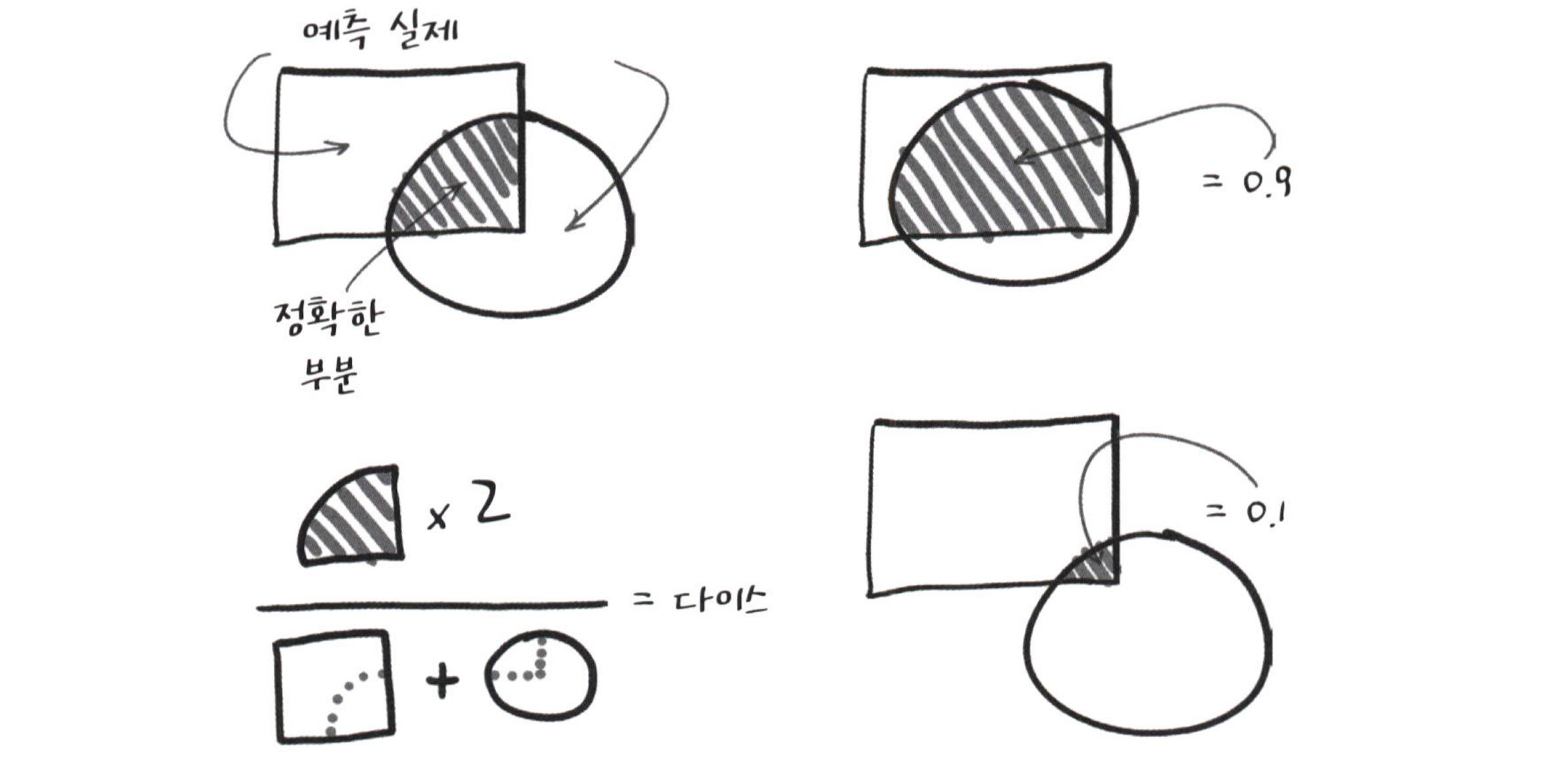

- 다이스 계수는 픽셀 단위의 F1 score
    - 이미지의 픽셀을 대상으로 하는 픽셀당 F1 score
    - 개별 샘플의 픽셀에 대해 값을 구할 수 있으므로 훈련 시 각 배치에 대한 손실값으로 사용 가능
    - cf) 분류의 F1 score는 전체 결과에 대한 성능 지표로 사용

In [ ]:
    def diceLoss(self, prediction_g, label_g, epsilon=1):
        diceLabel_g = label_g.sum(dim=[1,2,3]) # 양성 레이블
        dicePrediction_g = prediction_g.sum(dim=[1,2,3]) # 양성 예측
        diceCorrect_g = (prediction_g * label_g).sum(dim=[1,2,3]) # TP (label_g가 불린 마스크이므로 곱으로 TP 계산 가능)

        # 다이스 비율(dice ratio)
        diceRatio_g = (2 * diceCorrect_g + epsilon) \ # 분자와 분모에 epsilon(=1)을 더하여 예측과 레이블 모두 없는 경우를 해결
            / (dicePrediction_g + diceLabel_g + epsilon)

        return 1 - diceRatio_g # 손실로 만들기 위해 1에서 뺀 값을 반환 (작을수록 좋은 값으로 변환)

### Batch Loss
- 가중치 손실(weighted loss) 도입
    - 다운샘플링, 훈련 샘플 크롭 등 class imbalance를 해결하기 위한 방법과 유사
    - 양성 픽셀이 True 레이블인 fnLoss_g에 가중치를 곱하여 음성 픽셀에 가중 손실 부여
    - 양성 픽셀을 음성 픽셀보다 8배 중요하게 설정한다는 의미로 해석 가능
- 실제 양성 픽셀을 양성으로 세그멘테이션 하지 못한 경우에 가중 손실을 부여하여 재현율(recall)을 높이기 위한 방법

In [ ]:
    def computeBatchLoss(self, batch_ndx, batch_tup, batch_size, metrics_g,
                         classificationThreshold=0.5):
        input_t, label_t, series_list, _slice_ndx_list = batch_tup

        input_g = input_t.to(self.device, non_blocking=True)
        label_g = label_t.to(self.device, non_blocking=True)

        # 훈련셋인 경우에만 augmentation 수행
        if self.segmentation_model.training and self.augmentation_dict:
            input_g, label_g = self.augmentation_model(input_g, label_g)

        prediction_g = self.segmentation_model(input_g) # 세그멘테이션 모델 실행

        # 다이스 손실 적용
        diceLoss_g = self.diceLoss(prediction_g, label_g) # 훈련 샘플에 대한 일반 다이스 손실값
        fnLoss_g = self.diceLoss(prediction_g * label_g, label_g) # label_g에 포함된 픽셀에 대한 다이스 손실값

        start_ndx = batch_ndx * batch_size
        end_ndx = start_ndx + input_t.size(0)

        with torch.no_grad():
            predictionBool_g = (prediction_g[:, 0:1]
                                > classificationThreshold).to(torch.float32) # 잘 맞힌 예측

            # TP, FP, FN 계산
            tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3])
            fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3])
            fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3])

            metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = diceLoss_g
            metrics_g[METRICS_TP_NDX, start_ndx:end_ndx] = tp
            metrics_g[METRICS_FN_NDX, start_ndx:end_ndx] = fn
            metrics_g[METRICS_FP_NDX, start_ndx:end_ndx] = fp

        return diceLoss_g.mean() + fnLoss_g.mean() * 8 # weighted loss

### Main

In [ ]:
    def main(self):
        log.info("Starting {}, {}".format(type(self).__name__, self.cli_args))

        # data loader
        train_dl = self.initTrainDl()
        val_dl = self.initValDl()

        best_score = 0.0 # best_score 초기값 설정
        self.validation_cadence = 5 # 몇 epoch마다 검증을 수행할지
        for epoch_ndx in range(1, self.cli_args.epochs + 1):
            log.info("Epoch {} of {}, {}/{} batches of size {}*{}".format(
                epoch_ndx,
                self.cli_args.epochs,
                len(train_dl),
                len(val_dl),
                self.cli_args.batch_size,
                (torch.cuda.device_count() if self.use_cuda else 1),
            ))

            trnMetrics_t = self.doTraining(epoch_ndx, train_dl) # epoch별 훈련
            self.logMetrics(epoch_ndx, 'trn', trnMetrics_t) # 메트릭 로깅

            # 검증은 최초 한 번 수행한 후 5 epoch마다 한 번씩 수행
            if epoch_ndx == 1 or epoch_ndx % self.validation_cadence == 0:
                valMetrics_t = self.doValidation(epoch_ndx, val_dl)
                score = self.logMetrics(epoch_ndx, 'val', valMetrics_t) # 5 epoch마다 검증셋의 recall 점수 계산
                best_score = max(score, best_score) # 현재 score와 비교하여 best_score 갱신

                self.saveModel('seg', epoch_ndx, score == best_score) # 현재 epoch의 점수가 최고 점수인 경우에만 모델을 저장

                # 이미지 로깅
                self.logImages(epoch_ndx, 'trn', train_dl)
                self.logImages(epoch_ndx, 'val', val_dl)

        self.trn_writer.close()
        self.val_writer.close()

- 이전 장에서 F1 score를 주요 지표로 사용했다면 이번에는 recall을 주요 지표로 사용
- 양성 마스크를 세그멘테이션하는 것이 목적이므로 실제 양성을 양성이라고 예측한 비율을 높이는 것이 중요
    - recall = TP / TP + FN

### 이미지 로깅
- 텐서보드가 한 번에 12개의 이미지를 보여주므로 훈련셋과 검증셋에서 각각 6개의 동일한 간격을 가지는 CT 단면을 추출하여 로깅

In [ ]:
    def logImages(self, epoch_ndx, mode_str, dl):
        self.segmentation_model.eval() # 추론 모드로 전환

        images = sorted(dl.dataset.series_list)[:12] # 12개의 CT 순서가 뒤섞여 있을 수 있으므로 series_uid로 정렬
        for series_ndx, series_uid in enumerate(images):
            ct = getCt(series_uid)

            # 각각의 단면에 대해 추론을 수행하는 과정 (computeBatchLoss와 유사)
            for slice_ndx in range(6):
                ct_ndx = slice_ndx * (ct.hu_a.shape[0] - 1) // 5 # CT 내에서 동일한 거리를 가지는 6개의 단면을 선택
                sample_tup = dl.dataset.getitem_fullSlice(series_uid, ct_ndx)

                ct_t, label_t, series_uid, ct_ndx = sample_tup # ct_t를 모델에 입력

                input_g = ct_t.to(self.device).unsqueeze(0)
                label_g = pos_g = label_t.to(self.device).unsqueeze(0)

                prediction_g = self.segmentation_model(input_g)[0]
                prediction_a = prediction_g.to('cpu').detach().numpy()[0] > 0.5
                label_a = label_g.cpu().numpy()[0][0] > 0.5

                ct_t[:-1,:,:] /= 2000
                ct_t[:-1,:,:] += 0.5

                ctSlice_a = ct_t[dl.dataset.contextSlices_count].numpy()

                # prediction_a를 화면에 표시하기 위한 RGB 이미지(image_a) 생성
                image_a = np.zeros((512, 512, 3), dtype=np.float32)
                image_a[:,:,:] = ctSlice_a.reshape((512,512,1)) # CT 밀도를 모든 RGB 채널에 할당하여 흑백 이미지 생성
                image_a[:,:,0] += prediction_a & (1 - label_a) # FP: 붉은색으로 이미지에 overlay (1에서 빼줘서 label 뒤집기)

                image_a[:,:,0] += (1 - prediction_a) & label_a # FN: 주황색
                image_a[:,:,1] += ((1 - prediction_a) & label_a) * 0.5 # R(1.0) + G(0.5)

                image_a[:,:,1] += prediction_a & label_a # TP: 녹색

                # 0과 1 사이의 값으로 정규화
                image_a *= 0.5 # 범위가 0에서 2인 데이터에 0.5를 곱하여 0과 1 사이의 값으로 변환
                image_a.clip(0, 1, image_a) # image_a 내 0보다 작은 값은 0으로, 1보다 큰 값은 1로 변경

                # 텐서보드에 이미지 전달
                writer = getattr(self, mode_str + '_writer')
                writer.add_image(
                    f'{mode_str}/{series_ndx}_prediction_{slice_ndx}',
                    image_a,
                    self.totalTrainingSamples_count,
                    dataformats='HWC', # 텐서보드에게 이미지 내부 축 순서가 HWC 임을 전달 (RGB 채널이 세 번째 축)
                )

                writer.flush()

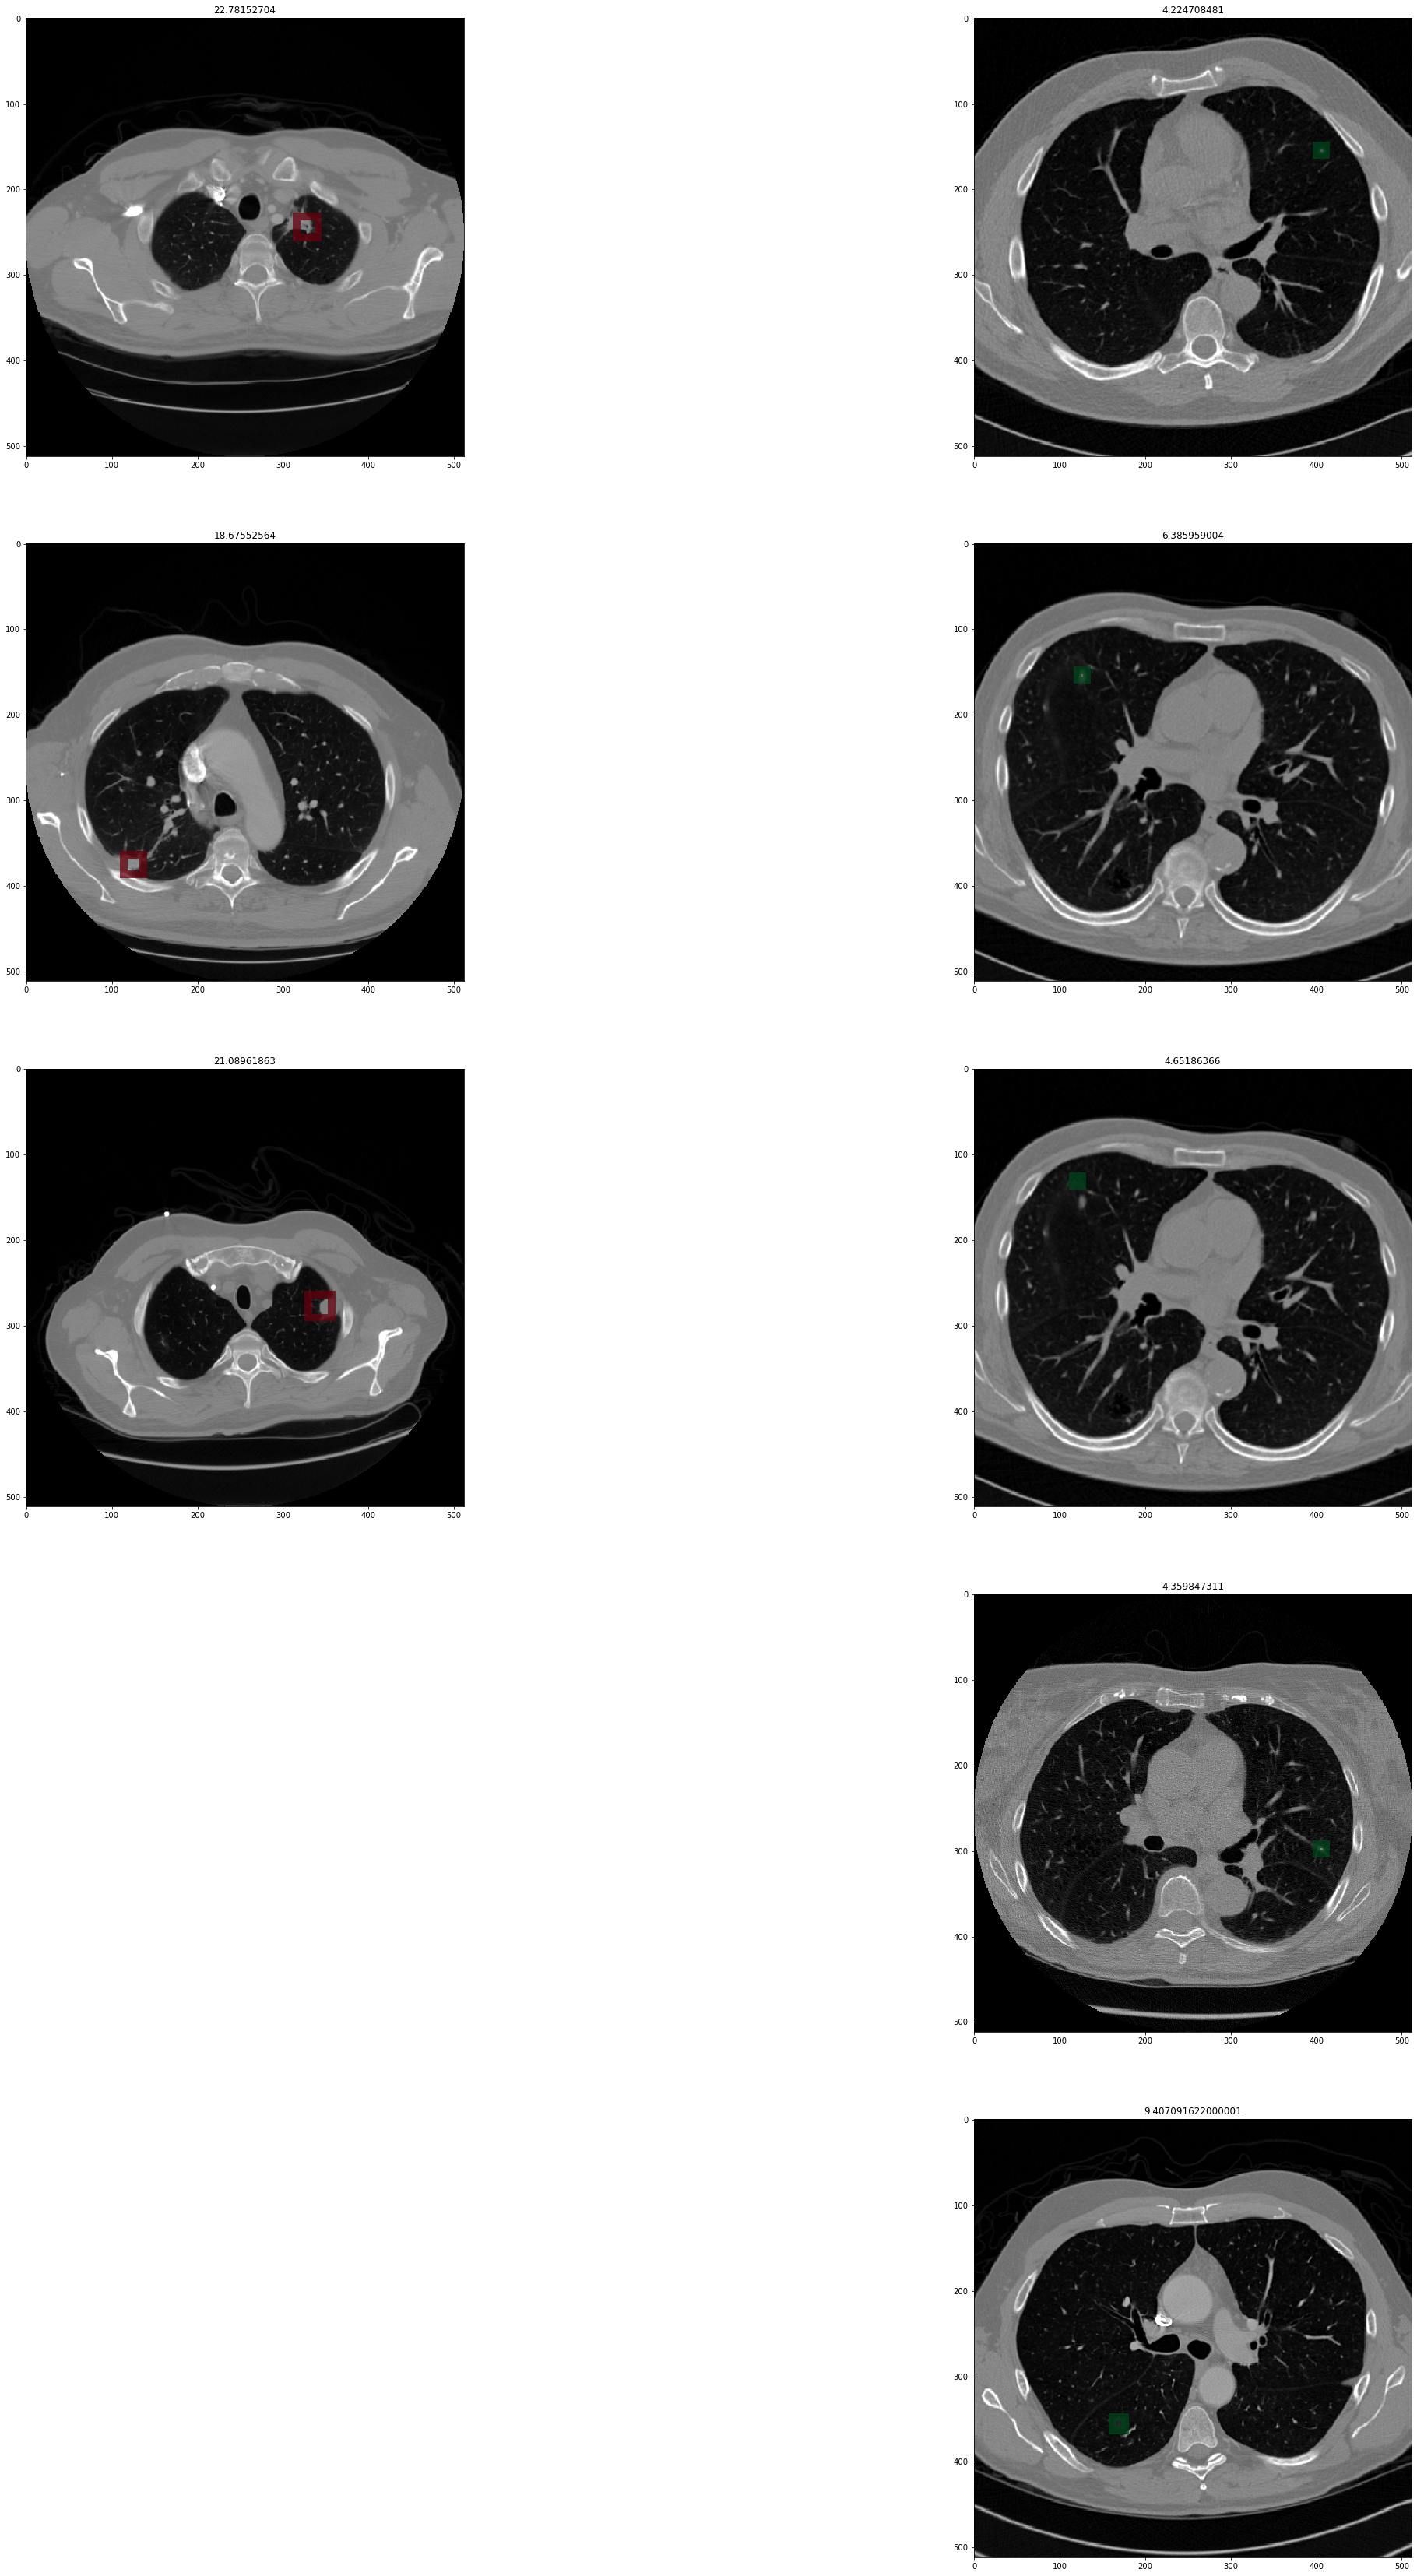

### 모델 저장 (torch.save)
- 모델 전체를 저장
    - pickle을 사용하여 모델 인스턴스를 저장
    - 모델 전체를 저장하므로 유연한 적용에 한계
- 모델의 파라미터만 저장
    - 저장된 모델과 클래스가 달라도 동일한 형태의 파라미터를 기대하는 어떤 모델에도 적용 가능
    - 모델 재사용 또는 모델 혼합 용이
    - model.state_dict() 함수를 사용하여 모델 파라미터 추출

In [ ]:
    def saveModel(self, type_str, epoch_ndx, isBest=False):
        file_path = os.path.join(
            'data-unversioned',
            'part2',
            'models',
            self.cli_args.tb_prefix,
            '{}_{}_{}.{}.state'.format(
                type_str,
                self.time_str,
                self.cli_args.comment,
                self.totalTrainingSamples_count,
            )
        )

        os.makedirs(os.path.dirname(file_path), mode=0o755, exist_ok=True)

        model = self.segmentation_model # 모델 호출
        if isinstance(model, torch.nn.DataParallel):
            model = model.module # DataParallel 레퍼런스가 있으면 제거

        state = {
            'sys_argv': sys.argv,
            'time': str(datetime.datetime.now()),
            'model_state': model.state_dict(), # 모델 파라미터
            'model_name': type(model).__name__,
            'optimizer_state' : self.optimizer.state_dict(), # 옵티마이저: 연산 자원이 부족한 경우 훈련을 멈췄다가 재개
            'optimizer_name': type(self.optimizer).__name__,
            'epoch': epoch_ndx,
            'totalTrainingSamples_count': self.totalTrainingSamples_count,
        }
        torch.save(state, file_path) # 모델 저장

        log.info("Saved model params to {}".format(file_path))

        # best model이 갱신되면 state 복사본을 생성
        if isBest:
            best_path = os.path.join(
                'data-unversioned', 'part2', 'models',
                self.cli_args.tb_prefix,
                f'{type_str}_{self.time_str}_{self.cli_args.comment}.best.state')
            shutil.copyfile(file_path, best_path) # file_path를 best_path로 복사

            log.info("Saved model params to {}".format(best_path))

## 13.7 결과

In [ ]:
# python -m p2ch13.training --epochs 20 --augmented final_seg

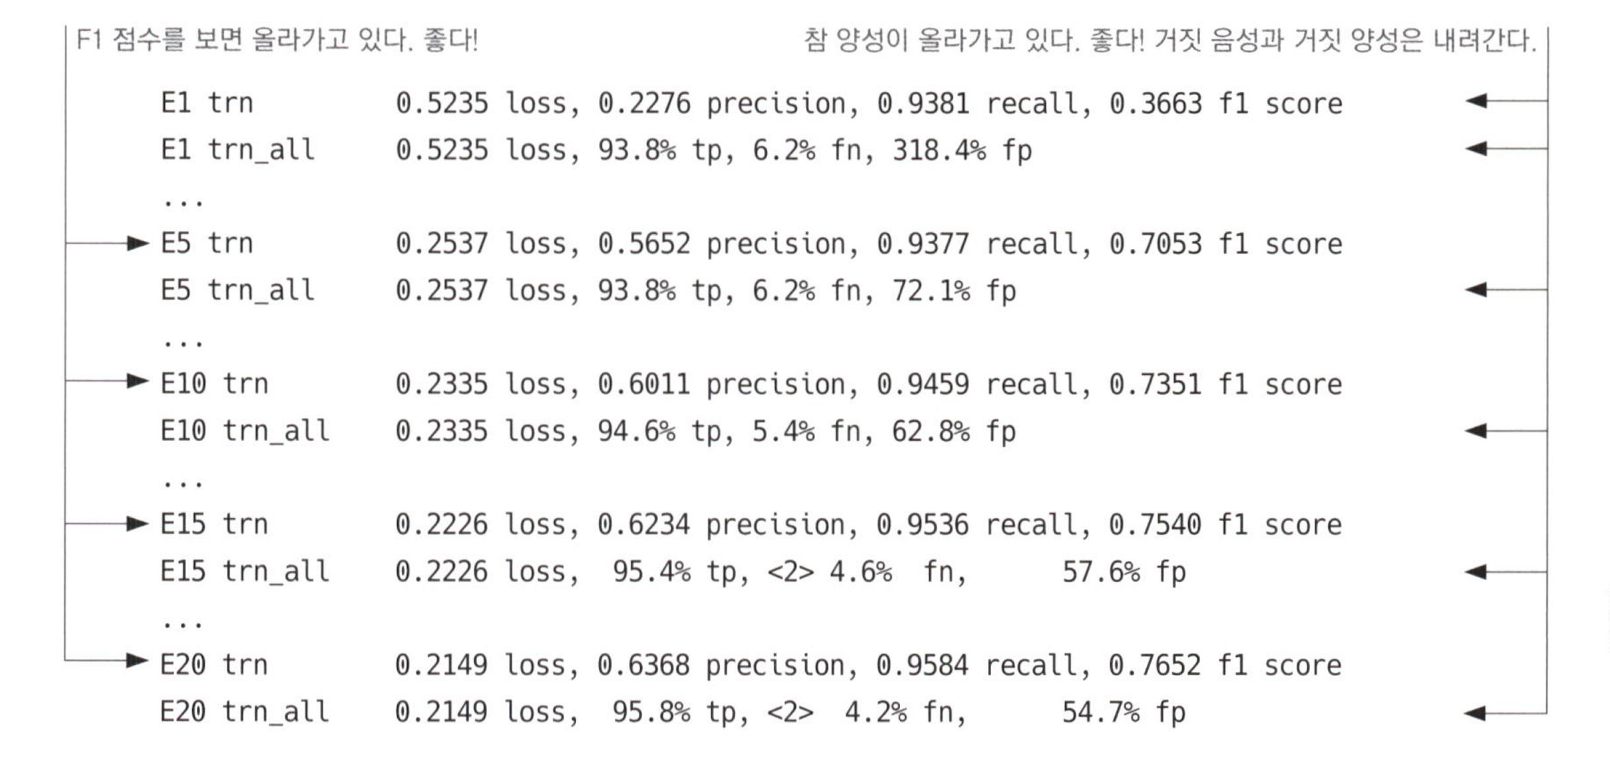

- TP, F1 score가 증가하고 FP, FN은 감소하는 추세 (긍정적)

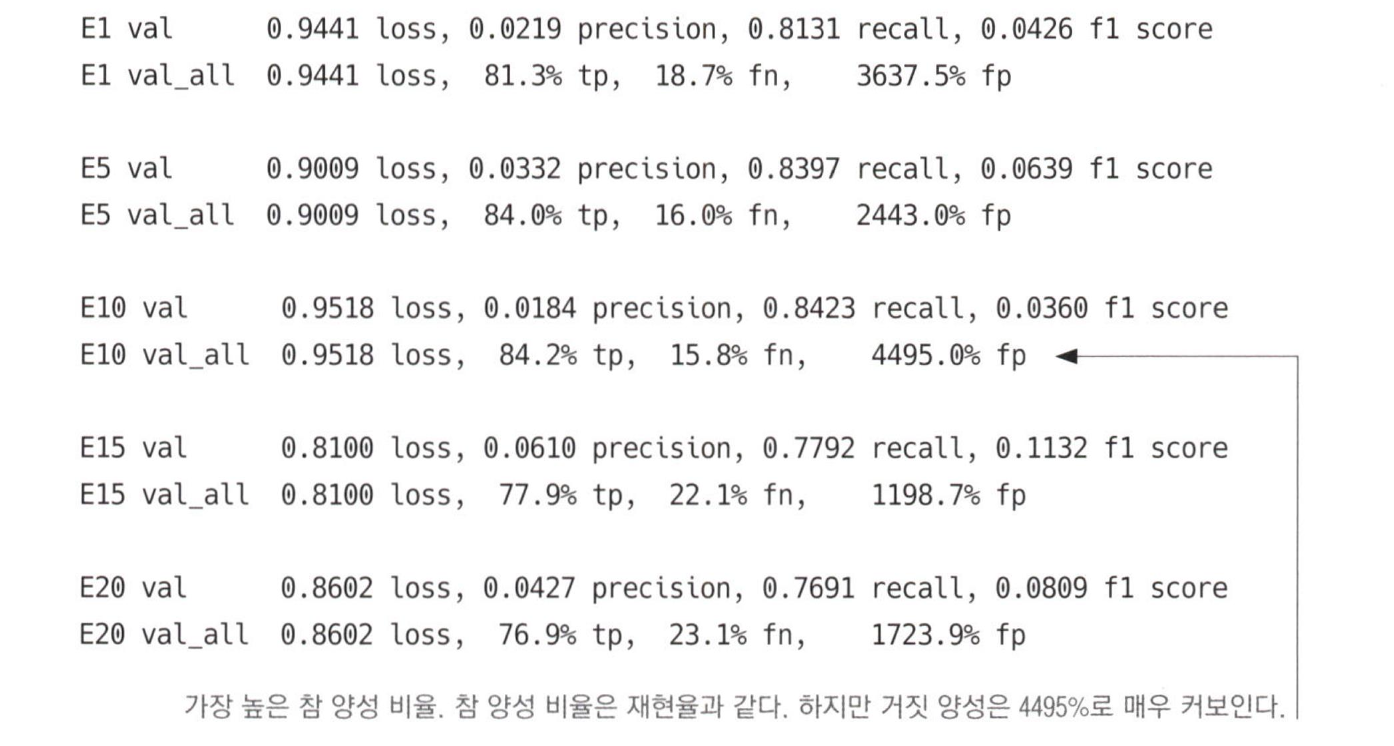

- 훈련셋은 64 * 64, 검증셋은 512 * 512 단면이므로 TP, FN, FP의 비율에는 당연히 차이가 존재
    - 검증용 단면의 표면이 훈련용 단면에 비해 64배 크므로 검증셋의 FP 비율이 4000%가 넘는 것은 정상

### 과적합(overfitting)
- epoch 10을 넘어가면서 검증셋의 recall이 지속적으로 감소
    - 훈련셋의 recall은 계속 증가하는 것으로 보아 과적합 발생

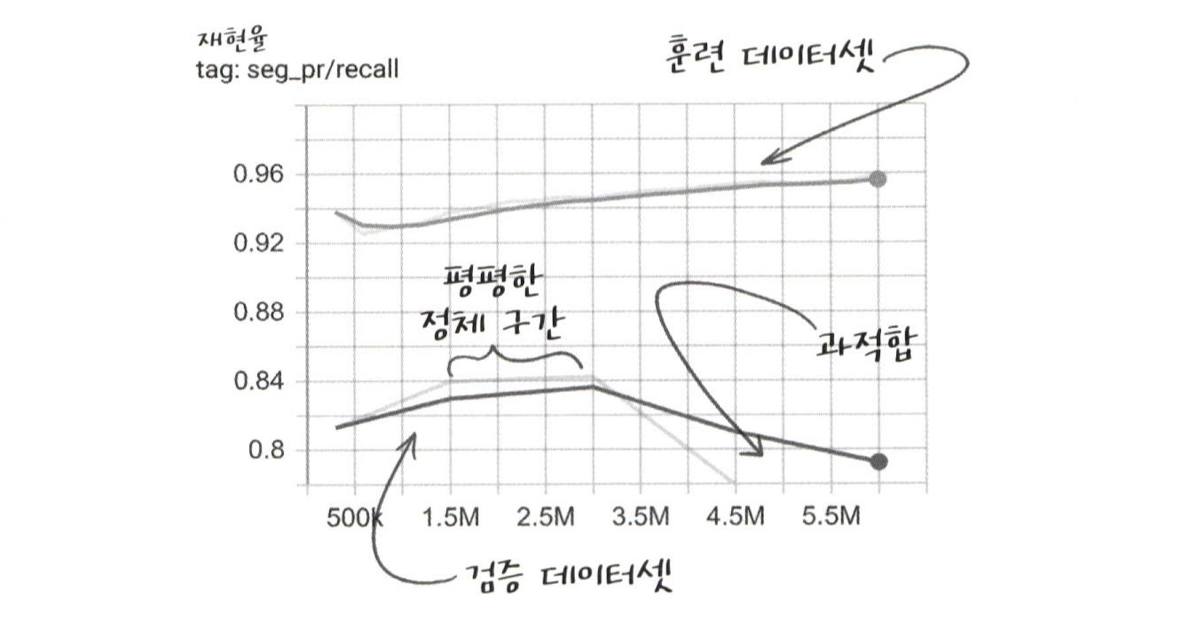